In [ ]:
# Notebook for the design of a simple FIR filter for feasiblity testing

from scipy import signal
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Chirp data generate
n=3000 # number of samples to use for the chirp
fs=20000 # The sampling rate for the chrip
f0=100# the start frequency in Hz for the chirp
f1=1000 # the stop frequency of the chirp
t1=n/fs # the total length of the chirp in s

t_chrip = np.linspace(0, t1, n)
# generate a chrip and scale to int16 (1 bit for sign)
y_chrip = signal.chirp(t_chrip, f0=f0, f1=f1, t1=t1, method='linear')
# y_chrip = y_chrip
# t_chrip = t_chrip

Text(0.5, 0, 'Normalized frequency (1.0 = Nyquist)')

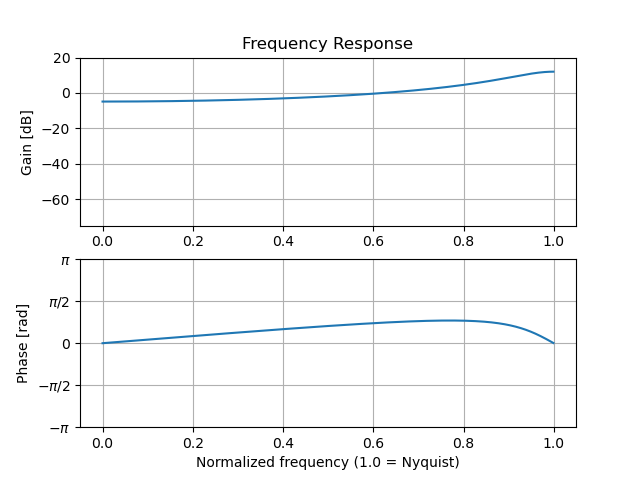

In [ ]:
# Plot a iir filter with fixed coefficients in sos form
%matplotlib widget

sos = np.array([ #[b0,b1,b2,a0,a1,a2]
    [1, 0, 0, 1.0, 0.75,0]
                ])
w, h = signal.sosfreqz(sos, worN=1500)
plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w/np.pi, db)
plt.ylim(-75, 5)
plt.grid(True)
plt.yticks([20, 0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h))
plt.grid(True)
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')


interactive(children=(IntSlider(value=2, description='order'), IntSlider(value=500, description='f_cut', max=5…

<function __main__.update(order=2, f_cut=500, fix_point=False, scale_bits=30)>

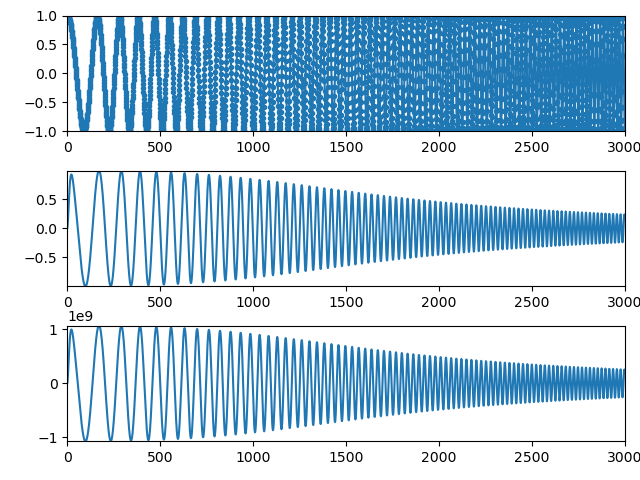

In [ ]:
%matplotlib widget
def iir_filter(b, data, fix_point=False, scale_bits=31):
    """single iir biquad filter element implementation in plain python

    Args:
        b (list): The filter coefficients in second order notation [b0,b1,b2,a0,a1,a2] a0 has to be normalized to 1.
        data (list): The data to filter
        fix_point (bool, optional): If checked, fixed point implementation is used. Defaults to False.
        scale_bits (int, optional): The bits to use for the scaling. Defaults to 31. Use e.g. 30 if there is a coefficient > 1

    Returns:
        _type_: _description_
    """
    # // file : iirdirect.c
    # // Low pass filter:
    # // Sample frequency (Hz) : 44000
    # // Cut off frequency (Hz) : 5000
    # // Damping factor : 1.5
    # const double a = 0.0409501; // m = 2, s = 1
    # const double b = 0.170625;
    # const double g = 0.506825;
    # const int C[5] = {
    # as_int(a), as_int(2*a), as_int(a), as_int(g), as_int(-b)
    # };
    # int xd[2];
    # int yd[2];
    # int low_pass(int x)
    # {
    # accum_t sum = fract_mult(x, C[0])
    # + fract_mult(xd[0],C[1]) + fract_mult(xd[1],C[2])
    # + fract_mult(yd[0],C[3]) + fract_mult(yd[1],C[4]);
    # int y = rnd_saturate(sum << 1);
    # xd[1] = xd[0];
    # xd[0] = x;
    # yd[1] = yd[0];
    # yd[0] = y;
    # return y;

    assert b[3] == 1, "a0 has to be normalized to 1"    
    scale = 2**scale_bits - 1
    y=[]
    if fix_point:
        C = (b*scale).astype(int).tolist() #* scale).astype(int).tolist()
        # xd = np.zeros(2, dtype=int)
        # yd = np.zeros(2, dtype=int)
        xd =[0]*2 
        yd = [0]*2
    else:
        C = b.tolist() #* scale).astype(int).tolist()
        xd =[0]*2 
        yd = [0]*2
    del C[3] # remove a0


    y_i=0
    for j in range(0, len(data)):
        if fix_point:
            x = int(scale*data[j])
        else:
            x = data[j]

        sum = x * C[0] + xd[0]*C[1] + xd[1]*C[2] - yd[0]*C[3] - yd[1]*C[4]
        
        if fix_point:
            y_i = sum >> scale_bits
        else:
            y_i = sum

        xd[1] = xd[0]
        xd[0] = x
        yd[1] = yd[0]
        yd[0] = y_i
        y.append(y_i)
    return y


cols = 1
rows = 3

fig = plt.figure(1)
ax1 = fig.add_subplot(rows, cols, 1)
line1, = ax1.plot([0], ".-", label = "chrip")
ax2 = fig.add_subplot(rows, cols, 2)
line2, = ax2.plot([0], label="chrip filtered signal.lfilter")
ax3 = fig.add_subplot(rows, cols, 3)
line3, = ax3.plot([0], label="own iir implementation")

def update(order = 2, f_cut=500, fix_point=False, scale_bits=30):
    # Calculate the filter coefficients for given paramters
    b=signal.iirfilter(order, f_cut, btype='lowpass', ftype='butter', output="sos", fs=fs) #returns [b0,b1,b2,a0,a1,a2]
    print(f"Filter coeffs for order {order} and {f_cut}Hz cutoff are:\n", b)
    
    # bits=16
    # if min(b)<0:
    #     bits=bits-1
    
    # plot the chirp
    line1.set_data(range(len(y_chrip)), y_chrip)
    ax1.set_xlim(0, len(y_chrip))
    ax1.set_ylim(min(y_chrip), max(y_chrip))

    # Apply the coefficents with scipy function
    y_lfiltered = signal.sosfilt(b, y_chrip)
    line2.set_data(range(len(y_lfiltered)), y_lfiltered)
    ax2.set_xlim(0, len(y_lfiltered))
    ax2.set_ylim(min(y_lfiltered), max(y_lfiltered))

    # Apply the coefficents with own implementation
    data = iir_filter(b[0], y_chrip, fix_point=fix_point, scale_bits=scale_bits)
    line3.set_data(range(len(data)), data)
    ax3.set_xlim(0, len(data))
    ax3.set_ylim(min(data), max(data))

    fig.canvas.draw_idle()
    # save coefficients to file
    # with open("pcm_data_processing/include/iir_coefficients.h", "w") as f:
    #     f.write(
    #         "#define NUMTAPS " + str(numtaps) + "\n" +
    #         "#define COEFFICIENTS {" + ",".join(np.array(np.array(np.round(b*(2**(bits)-1)), dtype=np.int32), dtype=str)) +"}" "\n"
    #     )

plt.tight_layout()
interact(update, order=(0, 100, 1), f_cut=(100,5000), fix_point=True, scale_bits=(1, 31, 1))

